# K-Means Clustering

Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. 
It uses the following assumptions: 

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Example: Generating a 2D dataset containiing 4 distinct blobs

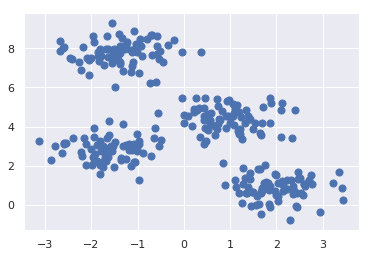

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

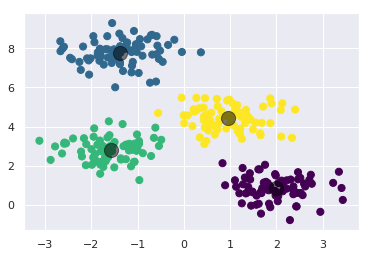

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### Behind the scenes of K-means - Expectation-Maximization

The Expectation-Maximization algorithm uses the following procedure: 

1) Guess some cluster centers <br/>
2) Repeat until converged:
- E-Step: assign points to the nearest cluster center
- M-Step: set the cluster centers to the mean

The E-step (Expectation step) is named because it involves updating our expectation of which cluster each point belongs to. 

The M-step (Maximization step) is named because it involves maximizing some function that defines the location of the cluster centers (such as the mean of data in each cluster)

#### Visualizing the Algorithm


Text(0.98, 0.98, 'Final Clustering')

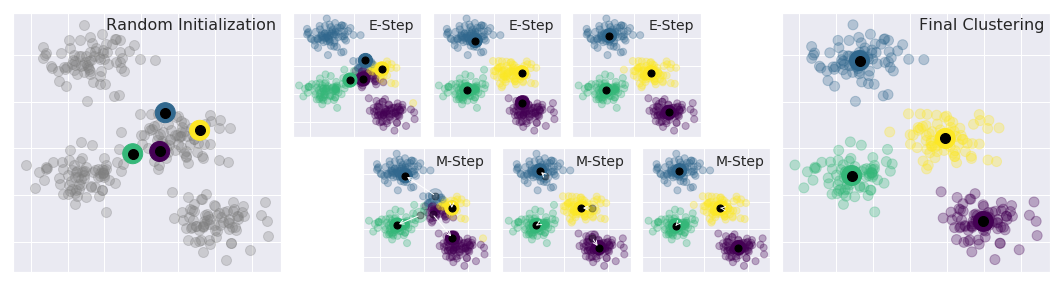

In [6]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)


#### Manual Implementation of K-Means algorithm

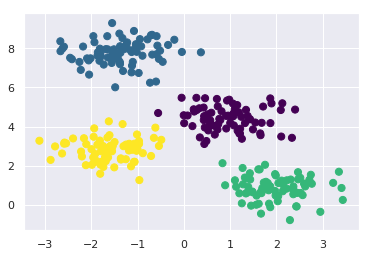

In [7]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Issues with Expectation-Maximization algorithm


#### Global Optimal Result may not be achieved

if we use a random seed, some starting guesses lead to poor results. 

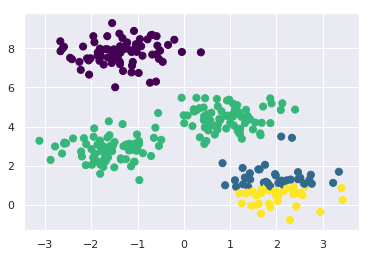

In [8]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

To solve this issue, we run the algorithm with multiple starting guesses. This is defined using the `n_init` parameter, which defaults to 10

#### The number of clusters must be selected beforehand

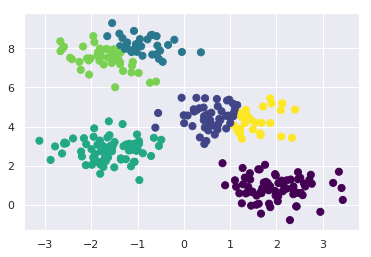

In [9]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

In the example above, the selected number of clusters (6) does not match the actual number of clusters (4)

A possible approach to selecting the appropriate number of clusters is silhouette analysis. https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Alternatively, we can use a more complicated clustering algorithm that can choose a suitable number of clusters. These are available in `sklearn.cluster`

#### K-means is limited to Linear Cluster boundaries

The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In [10]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

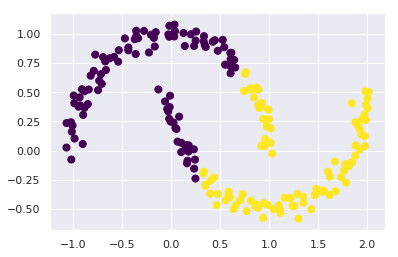

In [11]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We can use a kernelized K-means algorithm to discover non-linear boundaries. 

One example is the `SpectralClustering` estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


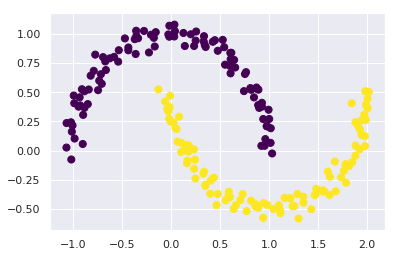

In [12]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

with this kernel transform approach, the kernelized k-means is able to find the more complicated nonlinear boundaries between clusters.

#### K-Means can be slow for large number of samples

Because each iteration of k-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.

To deal with this, we can subset the data and update the clusters in batches using `sklearn.cluster.MiniBatchKMeans`

### Example: K-Means on Digits

we will attempt to use k-means to try to identify similar digits without using the original label information

In [13]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [15]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

Let's take a look at the cluster centres

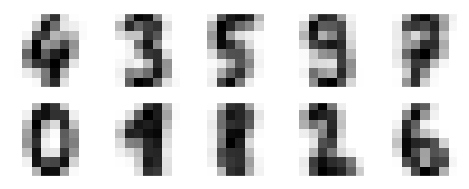

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Now let us compare the learned cluster labels and the actual cluster labels. 

In [17]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

Plotting a confusion matrix

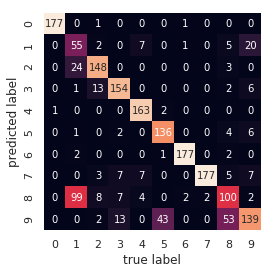

In [19]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Based on the matrix, we can see that the main point of confusion is between 8 and 1

To improve performance, we can use the t-SNE (Manifold learning) algorithm to pre-process the data before performing k-means

In [20]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9326655537006121

We can see that the accuracy has increased, up to 93%!

### Example 2: K-means for Color Compression

Imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

In this example, we will downscale an image to 16 bit to reduce the file size. 

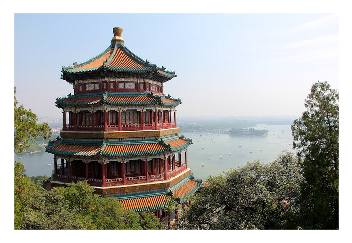

In [21]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size (height, width, RGB), containing red/blue/green contributions as integers from 0 to 255:

In [22]:
china.shape

(427, 640, 3)

we can view this set of pixels as a cloud of points in a three-dimensional color space. 

We will reshape the data to [n_samples x n_features], and rescale the colors so that they lie between 0 and 1:

In [23]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [24]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

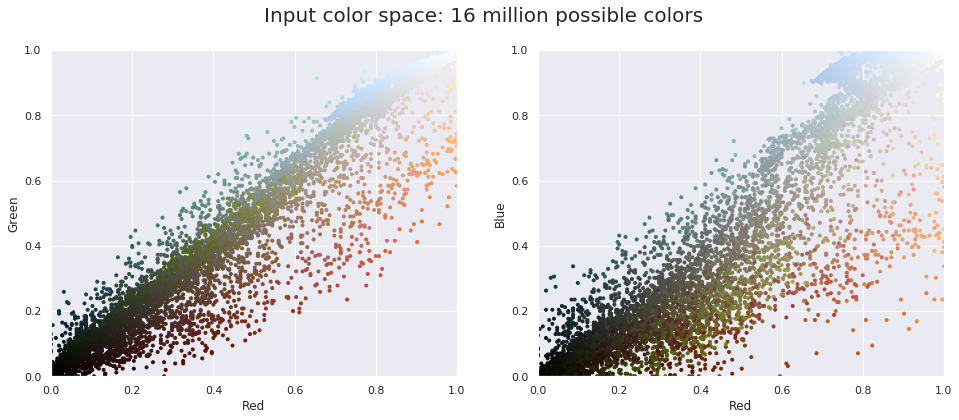

In [25]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space. 

Because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm:

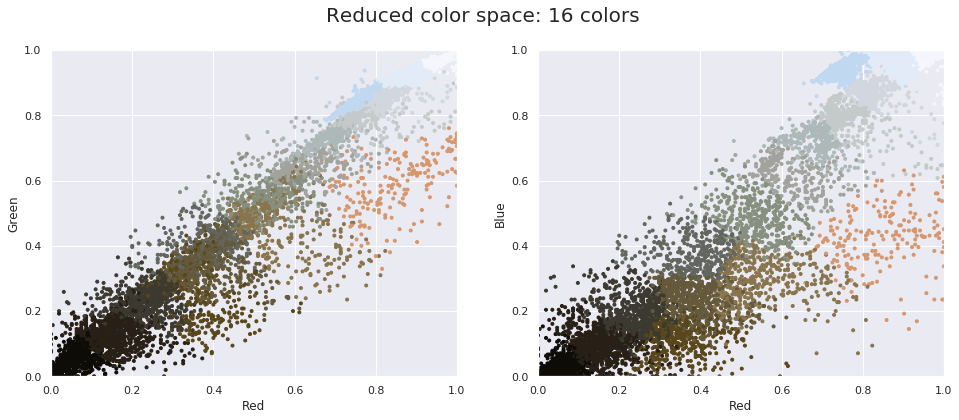

In [26]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center.

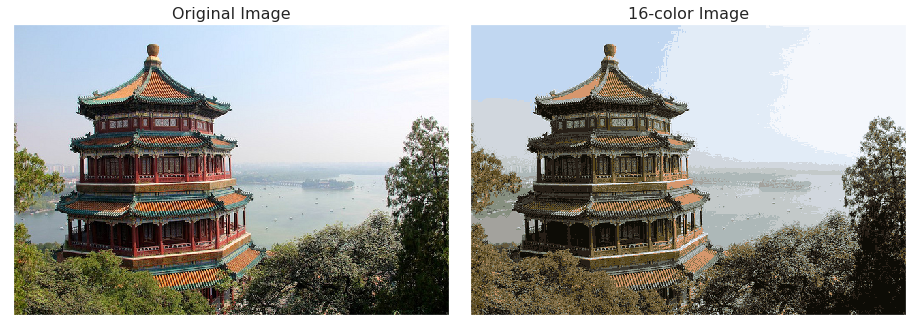

In [27]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Although some detail is lost in the right panel, the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million!